In [ ]:
#시스템 모듈
import numpy as np
import os
import copy
import time

#Image Handling 모듈
import matplotlib.pyplot as plt
from glob import glob
from skimage import io, transform
from PIL import Image

#Pytorch 모듈
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split


Mounted at /content/drive


In [ ]:
# DATA_PATH_TRAINING_LIST = glob('./CIFAR-10-images-master/train/*/*.jpg')
# DATA_PATH_TESTING_LIST = glob('./CIFAR-10-images-master/test/*/*.jpg')


In [ ]:
# ##__getitem__함수가 동작하지 않음!

# class MyCifarSet(Dataset) :
#     def __init__(self, data_path_list, classes, transform = None) :
#         #x : path_list
#         self.path_list = data_path_list
#         self.label = self.get_label(data_path_list)
#         self.transform = transform
#         #y : classes
#         self.classes = classes

#     def __len__(self) :
#         return len(self.path_list)

#     def get_label(self, data_path_list) :
#         label_list = []
#         for path in data_path_list :
#             label_list.append(path.split('/')[-2])
#         return label_list

#     def __getitem__(self, idx) :
#         if torch.is_tensor(idx) :
#             idx = idx.tolist()
#         image = io.imread(self.path_list[idx])
        
#         target = self.classes.index(self.label[idx])
#         if self.transform is not None :
#             image = self.transform(image)
#             target = self.transform(target)

#         return image, target


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


BatchSize = 4

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
torch.manual_seed(43)
valid_size = 10000
train_size = len(dataset) - valid_size
test_size = 10000
trainset, validset = random_split(dataset, [train_size, valid_size])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BatchSize, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BatchSize, shuffle=False, num_workers=2)




dataloaders = {'train': trainloader, 'valid' : validloader, 'test' : testloader}
datasizes = {'train' : train_size, 'valid' : valid_size, 'test' : test_size}

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#신경망에 모델을 학습시키는 함수를 정의하는 블럭

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, scheduler = None):
    since = time.time()
    trainloader = dataloaders['train']
    validloader = dataloaders['valid']
    testloader = dataloaders['test']
    trainloss = []
    validloss = []
    epochindex = []
    for epoch in range(num_epochs):
        model.train()
        print('Epoch {}/{} Start.'.format(epoch, num_epochs - 1))
        print('-' * 10)

        train_loss = 0.0
        valid_loss = 0.0

        # Iterate over data.
        # i : mini batch -> 40000/4 = 10000개
        # data : inputs, labels
        for i, data in enumerate(trainloader, 0):
            #inputs = inputs.to(device)
            #labels = labels.to(device)
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            train_loss += loss.item()
              
        train_loss = train_loss / len(trainloader)

        if(scheduler) :
            scheduler.step()

        with torch.no_grad():
            model.eval()
            for j, val in enumerate(validloader, 0) :
                inputs_val, labels_val = data
                outputs_val = model(inputs_val)
                loss = criterion(outputs_val, labels_val)
                valid_loss += loss.item()
                
            valid_loss = valid_loss / len(validloader)
        

        print('Done Epoch : %d ----- Train Loss : %.3f, Validation Loss : %.3f' % (epoch, train_loss, valid_loss))
        trainloss.append(train_loss)
        validloss.append(valid_loss)
        epochindex.append(epoch)

        train_loss = 0.0
        valid_loss = 0.0


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model, trainloss, validloss, epochindex


In [ ]:
#신경망을 정의하는 블럭

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5) # input channels, output channels, kernel size
        self.pool = nn.MaxPool2d(2, 2, 1)  # kernel size, stride, padding = 0 (default)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.fc1 = nn.Linear(128 * 2 * 2, 192) # input features, output features
        self.fc2 = nn.Linear(192, 128)
        self.fc3 = nn.Linear(128, 84)
        self.fc4 = nn.Linear(84, 10)
        self.dropout1 = nn.Dropout(p=0.5, inplace=False)

    def forward(self, x):
        x = self.pool(self.dropout1(F.relu(self.conv1(x))))
        x = self.pool(self.dropout1(F.relu(self.conv2(x))))
        x = self.pool(self.dropout1(F.relu(self.conv3(x))))
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net()

In [ ]:
#Device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

#Parameter 설정
criterion = nn.CrossEntropyLoss()
#optimizer_ft = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer_ft, gamma=0.95)


True


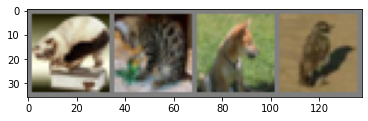

  cat   cat   dog  bird


In [ ]:

#데이터셋 로드 테스트

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(BatchSize)))

Epoch 0/39 Start.
----------
Done Epoch : 0 ----- Train Loss : 1.473, Validation Loss : 1.187
Epoch 1/39 Start.
----------
Done Epoch : 1 ----- Train Loss : 1.370, Validation Loss : 0.936
Epoch 2/39 Start.
----------
Done Epoch : 2 ----- Train Loss : 1.296, Validation Loss : 1.483
Epoch 3/39 Start.
----------
Done Epoch : 3 ----- Train Loss : 1.234, Validation Loss : 1.013
Epoch 4/39 Start.
----------
Done Epoch : 4 ----- Train Loss : 1.174, Validation Loss : 1.552
Epoch 5/39 Start.
----------
Done Epoch : 5 ----- Train Loss : 1.136, Validation Loss : 1.041
Epoch 6/39 Start.
----------
Done Epoch : 6 ----- Train Loss : 1.081, Validation Loss : 1.262
Epoch 7/39 Start.
----------
Done Epoch : 7 ----- Train Loss : 1.043, Validation Loss : 1.808
Epoch 8/39 Start.
----------
Done Epoch : 8 ----- Train Loss : 1.011, Validation Loss : 1.368
Epoch 9/39 Start.
----------
Done Epoch : 9 ----- Train Loss : 0.975, Validation Loss : 0.879
Epoch 10/39 Start.
----------
Done Epoch : 10 ----- Train Lo

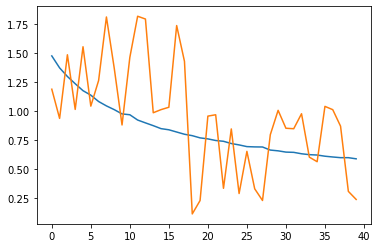

NameError: ignored

In [ ]:
#모델 학습
model_ft, trainloss, validloss, epochindex = train_model(net, dataloaders, criterion, optimizer_ft, num_epochs=40, scheduler=scheduler)

#Colab 안끊기게 하기
#Colab은 90분동안 사용자 입력이 없을 시 자동으로 런타임 연결을 해제합니다.
#웹브라우저 콘솔에 60초마다 한번씩 클릭을 해줘서 회피하는 방법입니다.
#사용법 : F12 -> Console(콘솔) 클릭 -> 코드 복사-붙여넣기(앞에 주석은 떼주세요! Javascript코드입니다.)
#function ClickConnect(){
#    console.log("코랩 연결 끊김 방지");
#    document.querySelector("colab-toolbar-button#connect").click()
#}
#setInterval(ClickConnect, 60 * 1000)

#학습결과를 파일으로 저장
#돌려놓고 갔다와도 학습결과가 파일으로 저장되어 있기 때문에 런타임이 끊겨도 이 코준블럭은 안돌려도 됩니다.
#저장위치 : Colab Notebooks 폴더 내에 'results'폴더를 만들고 실행하면 거기에 pth(파이토치 파일형식)파일형태로 저장이 됩니다.
#파일 생성시 시간이 기록됩니다.(UTC 기준)
PATH = './results/cifar_net__' + time.strftime('%Y-%m-%d_%H:%M:%S', time.localtime(time.time()))
torch.save(net.state_dict(), PATH + '.pth')

fig = plt.figure()
plt.plot(epochindex, trainloss)
plt.plot(epochindex, validloss)
plt.show()
plt.savefig(PATH + 'loss.png')

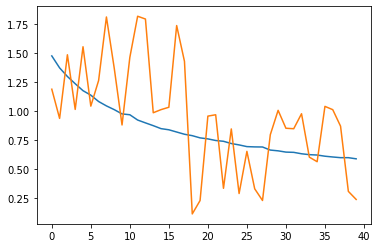

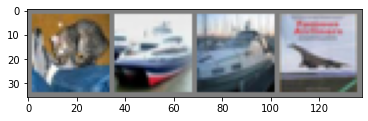

GroundTruth:    cat  ship  ship airplane
Predicted:    cat  ship  ship airplane


In [ ]:
#이미지 판별 테스트
#저장된 파일을 불러올땐 파일이름을 다음에 입력하세요.
#PATH = './results/nodeX2_explr.pth'

dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
#net = Net()
net.load_state_dict(torch.load(PATH + ".pth"))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
#정확도 측정
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    test_loss = 0.0
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class정를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 72 %
